In [71]:
from swc_utils import load_swc, visualize_swc, visualize_swc_interactive, print_compartment_types
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import fnmatch
from pynwb import NWBHDF5IO, NWBFile, TimeSeries

from jax import jit
import jaxley as jx
from jaxley.channels import Leak
from Allen_mech import * 

In [66]:
# load in swc file from patch_seq morph

ID = 601506507
raw_file= str(ID) + '_raw.swc'
trans_file = str(ID) + '_transformed.swc'
marker_file = str(ID) + '.marker'
base_dir = '/Users/elena.westeinde/Datasets/patch_seq_morphology'

raw_swc_file = os.path.join(base_dir, raw_file)
trans_swc_file = os.path.join(base_dir, trans_file)
marker_file = os.path.join(base_dir, marker_file)

raw_swc = load_swc(raw_swc_file)
trans_swc = load_swc(trans_swc_file)

metadata_file = '/Users/elena.westeinde/Datasets/specimen_metadata/20200711_patchseq_metadata_mouse.csv'
metadata = metadata = pd.read_csv(metadata_file)

metadata_cell = metadata[metadata['cell_specimen_id'] == ID]
ephys_ID = metadata_cell['ephys_session_id'].values[0]
metadata_cell.head()

/Users/elena.westeinde/Code/patch_seq/swc_utils.py:28: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead

/Users/elena.westeinde/Code/patch_seq/swc_utils.py:28: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead



,project,cell_specimen_id,cell_specimen_name,hemisphere,structure,donor_id,donor_name,biological_sex,age,ethnicity,...,apical_dendrite_status,neuron_reconstruction_type,cell_soma_normalized_depth,depth_from_pia_um,ephys_session_id,transcriptomics_sample_id,transcriptomics_batch,T-type Accession ID,T-type Label,MET-type Label
0,mIVSCC-MET,601506507,Vip-IRES-Cre;Ai14-331294.04.01.01,left,VISpm4,331294,Vip-IRES-Cre;Ai14-331294,M,P55,NaN,...,NaN,full,0.361015,NaN,601506492,PS0810_E1-50_S88,BT035,CS180626100018,Vip Gpc3 Slc18a3,Vip-MET-2


In [ ]:
print_compartment_types(raw_swc)

In [ ]:
print_compartment_types(trans_swc)

In [ ]:
visualize_swc_interactive(raw_swc)

In [39]:
visualize_swc_interactive(trans_swc)

# transformed swc has the same num compartments as raw swc, but has been corrected for rotation and translation. and tissue shrinking

## To Dos
* Generate Jaxley compartment model of cell 
* Alter compartments/segment by length --> might need to correct some jaxley code directly
* Decide on initial distributions & identities of ion channels in dendrites/axons/soma
* Decide on initial R, C, passive property values & idenities
* Load & reformat (if necessary) target cell responses to experimental stimuli
* Create equivalent model input
* Fit model to target responses, test on held out data

In [40]:
# altering the jx.read_swc function to make ncomps/branch dep on branch length might actually be not too hard
# go in and change line 150-151 in jaxley/io/swc.py
# 1 + 2 * int(L/(2*dL)), with L = branch length, dL = compartment length
ncomp = 4
cell = jx.read_swc(trans_swc_file, ncomp, max_branch_len=2000.0)
print(cell.shape)
print(list(cell.groups.keys()))

(63, 252)
['soma', 'axon', 'basal']


/Users/elena.westeinde/miniforge3/envs/jax_cpu/lib/python3.12/site-packages/jaxley/io/swc.py:44: UserWarning:

Found a soma which consists of a single traced point. `Jaxley` interprets this soma as a spherical compartment with radius specified in the SWC file, i.e. with surface area 4*pi*r*r.



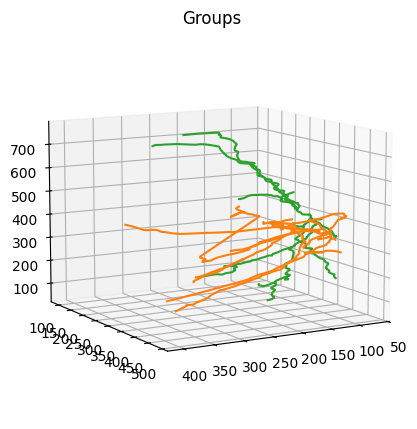

In [41]:
colors = plt.cm.tab10.colors
# make 3D plot
fig = plt.figure(figsize=(5,15))
ax = fig.add_subplot(111, projection='3d')
cell.basal.vis(ax=ax, col=colors[2],dims=[2,0,1])
cell.axon.vis(ax=ax, col=colors[1],dims=[2,0,1])
cell.soma.vis(ax=ax, col=colors[0],dims=[2,0,1])
ax.view_init(elev=10, azim=60)
plt.title("Groups")
plt.show()




## Add Mechanisms

In [42]:
# currently only inserted active channels into only the soma, elsewhere only has passive currents re Allen soma biophysical models: 
# will want to extend active channels to other compartments as well
cell.set("v", -94.8687744140625) # initial voltage


###########PASSIVE###############

# Capacitance (cm)
for sec in cell.groups["basal"]:
    cell.scope('global').comp(sec).set('capacitance', 3.0836282881231423) #uF/cm^2


# Axial resistance (Ra)
cell.set('axial_resistivity', 95.8898309982) # ohm cm

# Leak
cell.insert(Leak()) # Will need to verify equivalency to NEURON g_pas and e_pas
cell.set("Leak_eLeak", -94.8687744140625) 

for sec in cell.groups["basal"]:
    cell.scope('global').comp(sec).set('Leak_gLeak', 1.0122171676802016e-07)

for sec in cell.groups["axon"]:
    cell.scope('global').comp(sec).set('Leak_gLeak', 0.00023937249764681342)

for sec in cell.groups["soma"]:
    cell.scope('global').comp(sec).set('Leak_gLeak', 0.00028577028203653131)


###########ACTIVE###############

for sec in cell.groups["soma"]:
#     #Im
    cell.scope('global').comp(sec).insert(M())
    cell.scope('global').comp(sec).set('M_gM', 0.00013184773347288403)
#     #Ih
    cell.scope('global').comp(sec).insert(H())
    cell.scope('global').comp(sec).set('H_gH', 3.3432437931859737e-06)
# #     # NaTs
    cell.scope('global').comp(sec).insert(NaTs())
    cell.scope('global').comp(sec).set('NaTs_gNaTs', 0.47992172908442654)
# #     #NaP
    cell.scope('global').comp(sec).insert(Nap())
    cell.scope('global').comp(sec).set('Nap_gNap', 3.2726729953750505e-06)
#     # Kp 
    cell.scope('global').comp(sec).insert(K_P())
    cell.scope('global').comp(sec).set('K_P_gK_P', 0.041566912788983203)
#     # KT
    cell.scope('global').comp(sec).insert(K_T())
    cell.scope('global').comp(sec).set('K_T_gK_T', 0.0019124672267998672)
#     # SK
    cell.scope('global').comp(sec).insert(SKE2())
    cell.scope('global').comp(sec).set('SKE2_gSKE2', 0.00036975020657043552)
#     # Kv3_1
    cell.scope('global').comp(sec).insert(SKv3_1())
    cell.scope('global').comp(sec).set('SKv3_1_gSKv3_1', 0.034245907441817838)
# #     # Ca_HVA
    cell.scope('global').comp(sec).insert(CaHVA())
    cell.scope('global').comp(sec).set('CaHVA_gCaHVA', 1.2137274457028284e-05)
#     # Ca_LVA
    cell.scope('global').comp(sec).insert(CaLVA())
    cell.scope('global').comp(sec).set('CaLVA_gCaLVA', 0.00025557429098146782)
    # Ca pump
    cell.scope('global').comp(sec).insert(CaPump_NEURON()) # shell depth matches allen
    cell.scope('global').comp(sec).set('CaPump_NEURON_gamma', 0.048059126133381751)
    cell.scope('global').comp(sec).set('CaPump_NEURON_decay', 588.80429238218176)

#     # reversal potentials & concentrations
#     # shared channel parameters overwrite eachother, set final parameter values after adding all the channels
    cell.scope('global').comp(sec).insert(CaNernstReversal())
    cell.scope('global').comp(sec).set('eK', -107.0)
    cell.scope('global').comp(sec).set('eNa', 53.0)
    cell.scope('global').comp(sec).set('CaCon_e', 2) # mM units
    cell.scope('global').comp(sec).set('CaCon_i', 1e-04) # mM units
    
# compute intial states
cell.init_states()

node_list = cell.nodes

## Load target data





In [81]:
data_path = '/Users/elena.westeinde/Datasets/electrophysiology'
data_folder = 'sub-' + str(ID)
# dir_path = os.path.join(data_path, data_folder)
# dir_files = os.listdir(dir_path)
# print(dir_files)

def find_files(substring, directory):
    matching_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if substring in file:
                matching_files.append(os.path.join(root, file))
    return matching_files

matching_files = find_files(str(ephys_ID), data_path)
print(matching_files)

for file in matching_files:
    with NWBHDF5IO(file, "r") as io:
        nwbfile = io.read()
        print(nwbfile.acquisition.keys())
        test = nwbfile.acquisition['data_00001_AD0']

['/Users/elena.westeinde/Datasets/electrophysiology/sub-599387254/sub-599387254_ses-601506492_icephys.nwb']


/Users/elena.westeinde/miniforge3/envs/jax_cpu/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning:

Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.

/Users/elena.westeinde/miniforge3/envs/jax_cpu/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning:

Ignoring cached namespace 'core' version 2.2.5 because version 2.7.0 is already loaded.



dict_keys(['data_00000_AD0', 'data_00001_AD0', 'data_00002_AD0', 'data_00003_AD0', 'data_00004_AD0', 'data_00005_AD0', 'data_00006_AD0', 'data_00007_AD0', 'data_00008_AD0', 'data_00009_AD0', 'data_00010_AD0', 'data_00011_AD0', 'data_00012_AD0', 'data_00013_AD0', 'data_00014_AD0', 'data_00015_AD0', 'data_00016_AD0', 'data_00017_AD0', 'data_00018_AD0', 'data_00019_AD0', 'data_00020_AD0', 'data_00021_AD0', 'data_00022_AD0', 'data_00023_AD0', 'data_00024_AD0', 'data_00025_AD0', 'data_00026_AD0', 'data_00027_AD0', 'data_00028_AD0', 'data_00029_AD0', 'data_00030_AD0', 'data_00031_AD0', 'data_00032_AD0', 'data_00033_AD0', 'data_00034_AD0', 'data_00035_AD0', 'data_00036_AD0', 'data_00037_AD0', 'data_00038_AD0', 'data_00039_AD0', 'data_00040_AD0', 'data_00041_AD0', 'data_00042_AD0', 'data_00043_AD0', 'data_00044_AD0', 'data_00045_AD0', 'data_00046_AD0', 'data_00047_AD0', 'data_00048_AD0', 'data_00049_AD0'])


In [97]:
print(nwbfile.stimulus['data_00001_DA0']) #acquisition['data_00001_AD0'].stimulus


data_00001_DA0 pynwb.icephys.VoltageClampStimulusSeries at 0x14527419632
Fields:
  comments: 1:52:56 PM
Untitled - Igor Pro 7.02
MiesVersion: Release_1.1_20170110-49-gbd33118
HS#0:Stim Wave Name: EXTPINBATH141203_DA_0

HS#0:Pipette Offset: 67.14 mV

HS#0:TP Baseline Vm: nan mV
HS#0:TP Peak Resistance: 17.51 Mohm
HS#0:TP Steady State Resistance: 2541.34 Mohm

  conversion: 0.0010000000474974513
  description: PLACEHOLDER
  electrode: electrode_0 pynwb.icephys.IntracellularElectrode at 0x14529306144
Fields:
  description: Headstage 0
  device: device_ITC18USB_Dev_0 pynwb.device.Device at 0x14528274720
Fields:
  description: Harvard Bioscience (formerly HEKA/Instrutech) Model: ITC18USB


  gain: 20.0
  offset: 0.0
  rate: 50000.0
  resolution: nan
  starting_time: 422.4409999847412
  starting_time_unit: seconds
  stimulus_description: EXTPINBATH141203_DA_0
  sweep_number: 1
  unit: volts

